In [1]:
import sys
sys.path.append('../scripts/')
from puddle_world import *
import itertools 
import collections 

In [2]:
class PolicyEvaluator: 
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T):  #puddle_coef追加
        self.pose_min = np.r_[lowerleft, 0]
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.goal = goal
        
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        self.value_function, self.final_state_flags =  self.init_value_function() 
        self.policy = self.init_policy()
        self.actions = list(set([tuple(self.policy[i]) for i in self.indexes])) #追加（policyの行動をsetにすることで重複削除し、リスト化）
        
        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num)
        self.depths = self.depth_means(puddles, sampling_num)
        
        self.time_interval = time_interval
        self.puddle_coef = puddle_coef
        
    def policy_evaluation_sweep(self):   ###policyevaluator7
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                q = self.action_value(tuple(self.policy[index]), index)
                
                delta = abs(self.value_function[index] - q)
                max_delta = delta if delta > max_delta else max_delta
                
                self.value_function[index] = q
            
        return max_delta
    
    def action_value(self, action, index):
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]:  #index[2]: 方角のインデックス
            after = tuple(self.edge_correction(np.array(index).T + delta) ) #indexに差分deltaを足してはみ出し処理の後にタプルにする
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval
            value += (self.value_function[after] + reward) * prob

        return value
            
    def edge_correction(self, index):
        index[2] = (index[2] + self.index_nums[2])%self.index_nums[2] #方角の処理
                
        return index
        
    def depth_means(self, puddles, sampling_num):
        ###セルの中の座標を均等にsampling_num**2点サンプリング###
        dx = np.linspace(0, self.widths[0], sampling_num) 
        dy = np.linspace(0, self.widths[1], sampling_num)
        samples = list(itertools.product(dx, dy))
        
        tmp = np.zeros(self.index_nums[0:2]) #深さの合計が計算されて入る
        for xy in itertools.product(range(self.index_nums[0]), range(self.index_nums[1])):
            for s in samples:
                pose = self.pose_min + self.widths*np.array([xy[0], xy[1], 0]).T + np.array([s[0], s[1], 0]).T #セルの中心の座標
                for p in puddles:
                    tmp[xy] += p.depth*p.inside(pose) #深さに水たまりの中か否か（1 or 0）をかけて足す
                        
            tmp[xy] /= sampling_num**2 #深さの合計から平均値に変換
                       
        return tmp
    
    def init_state_transition_probs(self, time_interval, sampling_num):
        ###セルの中の座標を均等にsampling_num**3点サンプリング###
        dx = np.linspace(0.001, self.widths[0]*0.999, sampling_num) #隣のセルにはみ出さないように端を避ける
        dy = np.linspace(0.001, self.widths[1]*0.999, sampling_num)
        dt = np.linspace(0.001, self.widths[2]*0.999, sampling_num)
        samples = list(itertools.product(dx, dy, dt))
        
        ###各行動、各方角でサンプリングした点を移動してインデックスの増分を記録###
        tmp = {}
        for a in self.actions:
            for i_t in range(self.index_nums[2]):
                transitions = []
                for s in samples:
                    before = np.array([s[0], s[1], s[2] + i_t*self.widths[2]]).T + self.pose_min  #遷移前の姿勢
                    before_index = np.array([0, 0, i_t]).T                                                      #遷移前のインデックス
                
                    after = IdealRobot.state_transition(a[0], a[1], time_interval, before)   #遷移後の姿勢
                    after_index = np.floor((after - self.pose_min)/self.widths).astype(int)   #遷移後のインデックス
                    
                    transitions.append(after_index - before_index)                                  #インデックスの差分を追加
                    
                unique, count = np.unique(transitions, axis=0, return_counts=True)   #集計（どのセルへの遷移が何回か）
                probs = [c/sampling_num**3 for c in count]                   #サンプル数で割って確率にする
                tmp[a,i_t] = list(zip(unique, probs))
                
        return tmp
        
    def init_policy(self):
        tmp = np.zeros(np.r_[self.index_nums,2]) #制御出力が2次元なので、配列の次元を4次元に
        for index in self.indexes:
            center = self.pose_min + self.widths*(np.array(index).T + 0.5)  #セルの中心の座標
            tmp[index] = PuddleIgnoreAgent.policy(center, self.goal)
            
        return tmp
        
    def init_value_function(self): 
        v = np.empty(self.index_nums) #全離散状態を要素に持つ配列を作成
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index          #xy平面で左下の座標
        x_max, y_max, _ = self.pose_min + self.widths*(index + 1) #右上の座標（斜め上の離散状態の左下の座標）
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] #4隅の座標
        return all([self.goal.inside(np.array(c).T) for c in corners ])

In [3]:
import seaborn as sns   

puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 
pe = PolicyEvaluator(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles, 0.1, 10)

counter = 0 #スイープの回数

1 54.07622
2 53.85750528
3 47.920786948
4 43.1659928095
5 38.8261459959
6 34.9259025413
7 31.5594311171
8 31.5307356271
9 30.8763342696
10 29.7850133833
11 28.3587508538
12 26.8018106682
13 25.887832807
14 25.739418782
15 25.2819864586
16 24.5788821067
17 19.2545531019
18 17.9386987495
19 15.7763434333
20 14.5525312627
21 13.9762432926
22 12.8655316912
23 12.5702213722
24 11.9507179618
25 11.2596699915
26 10.3978959955
27 9.74742512521
28 9.45190263253
29 8.8998124154
30 8.62444814138
31 8.34035686017
32 7.94025942826
33 7.60503037271
34 7.29339946213
35 7.03300422668
36 6.81340850696
37 6.69907500211
38 6.56789245159
39 6.38027024317
40 6.2061096935
41 6.04407133776
42 5.89750660273
43 5.76394294178
44 5.63784613256
45 5.51871528534
46 5.40609686207
47 5.29957597445
48 5.19876903345
49 5.1033184533
50 5.01288911457
51 4.92716553532
52 4.84584928704
53 4.76865697367
54 4.66510599513
55 4.49997956417
56 4.44368820628
57 4.38758707238
58 4.30258099559
59 4.16487045859
60 3.98186098454
61

<IPython.core.display.Javascript object>


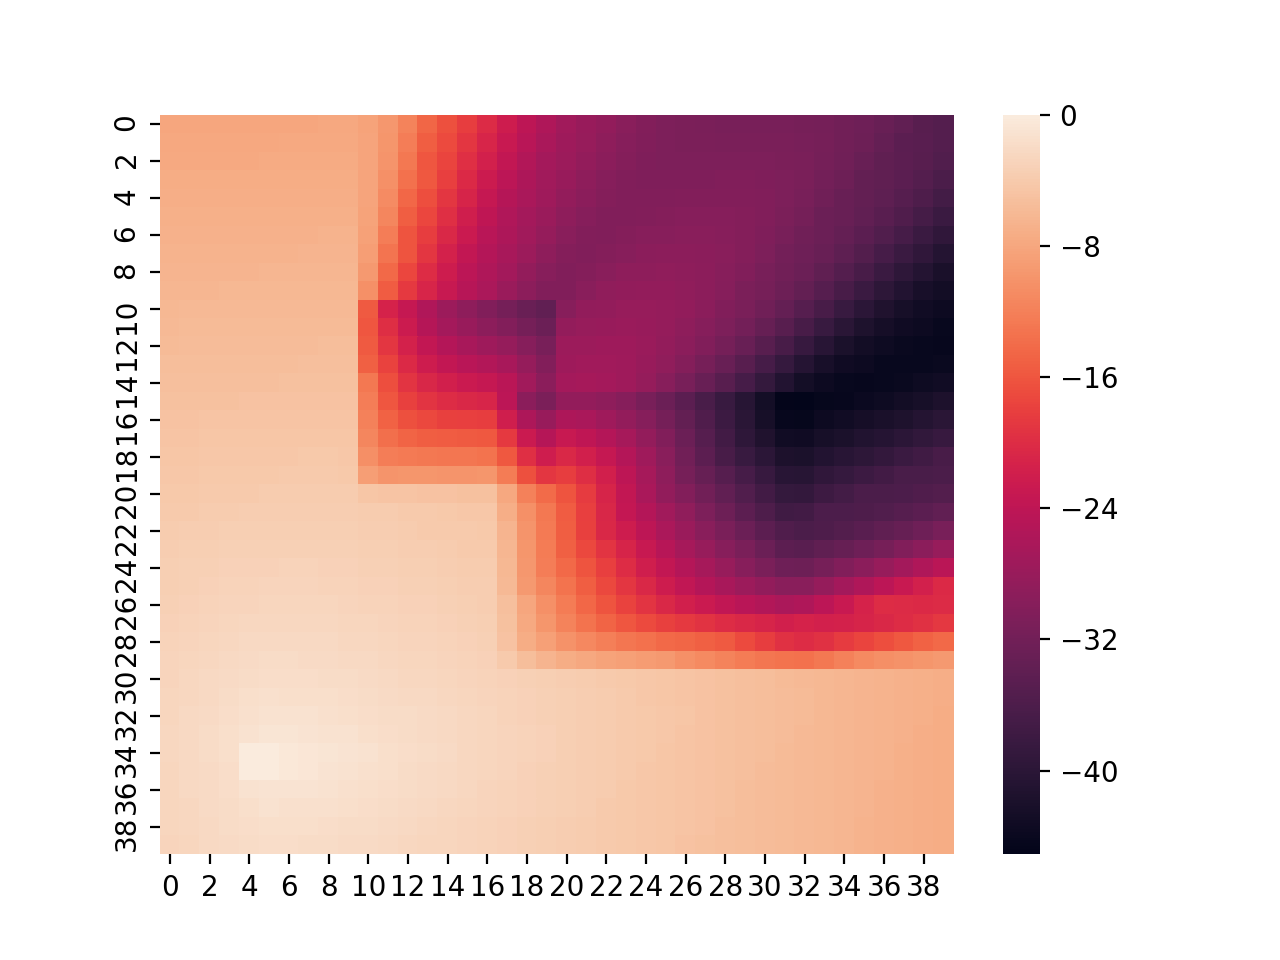

In [4]:
delta = 1e100

while delta > 0.01:  ###policyevaluator7exec
    delta = pe.policy_evaluation_sweep()
    counter += 1
    print(counter, delta)

v = pe.value_function[:, :, 18]
sns.heatmap(np.rot90(v), square=False)
plt.show()

In [5]:
with open("puddle_ignore_policy.txt", "w") as f:  ###savepolicyvalues
    for index in pe.indexes:
        p = pe.policy[index]
        f.write("{} {} {} {} {}\n".format(index[0], index[1], index[2], p[0], p[1]))
        
with open("puddle_ignore_values.txt", "w") as f:
    for index in pe.indexes:
        v = pe.value_function[index]
        f.write("{} {} {} {}\n".format(index[0], index[1], index[2],v))